# Detecting the difficulty level of French texts




In [1]:
#!pip install transformers

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import spacy
import pandas as pd
import numpy as np

c:\Users\DENIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df  = pd.read_csv('training_data.csv', index_col = 'id')


In [4]:
df.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [5]:
df.isnull().sum()

sentence      0
difficulty    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [30]:
X = df['sentence'].values

In [31]:
y = df['difficulty'].values

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
y_train.shape

(3840,)

In [34]:
X_train.shape

(3840,)

In [35]:
# Load CamemBERT tokenizer and model
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(df['difficulty'].unique()))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Tokenize the input data
def tokenize_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

In [37]:
print(y_train)
print(y_test)


['A2' 'A2' 'A1' ... 'C2' 'A1' 'A2']
['A1' 'A1' 'C2' 'B2' 'A2' 'C2' 'A1' 'A2' 'A1' 'C2' 'A2' 'A2' 'B2' 'B2'
 'C2' 'B2' 'A1' 'C2' 'A1' 'A1' 'B1' 'C1' 'B1' 'C2' 'A1' 'A2' 'A1' 'B1'
 'C2' 'A1' 'B1' 'B2' 'B1' 'B2' 'B1' 'C2' 'B1' 'C2' 'C1' 'A1' 'C2' 'B1'
 'B2' 'A2' 'C2' 'A2' 'A1' 'B1' 'B2' 'C1' 'B1' 'B2' 'B1' 'A1' 'C1' 'A1'
 'A1' 'C2' 'A1' 'A2' 'C2' 'C2' 'B1' 'C1' 'C1' 'B2' 'C2' 'A2' 'B2' 'B1'
 'C2' 'B2' 'A2' 'C2' 'A2' 'C1' 'A1' 'B1' 'A1' 'A2' 'A1' 'C2' 'C1' 'C1'
 'C1' 'A1' 'B1' 'C2' 'C2' 'A2' 'C2' 'C1' 'B2' 'A2' 'B1' 'B1' 'A1' 'A1'
 'B1' 'B2' 'B1' 'C2' 'B2' 'A2' 'A2' 'A1' 'C1' 'B1' 'B1' 'B1' 'B2' 'A1'
 'B1' 'A1' 'C1' 'A2' 'C1' 'C1' 'A2' 'A2' 'A2' 'A1' 'A2' 'C2' 'C1' 'A1'
 'B2' 'B2' 'A2' 'B2' 'B2' 'C1' 'A1' 'A2' 'B1' 'B2' 'C2' 'A2' 'A1' 'C2'
 'A2' 'C2' 'A2' 'B2' 'A1' 'B1' 'C2' 'A1' 'A2' 'C2' 'C1' 'C1' 'B2' 'B2'
 'B1' 'C2' 'C1' 'A2' 'A2' 'C1' 'A2' 'C1' 'C2' 'C2' 'C1' 'A1' 'A1' 'A2'
 'C1' 'B1' 'C2' 'B2' 'B2' 'A2' 'B1' 'B1' 'B1' 'C2' 'B2' 'C2' 'C1' 'A1'
 'C1' 'B2' 'B2' 'B2' 'A1' 'C1' 'A1' 'A2' 

In [40]:
    from sklearn.preprocessing import LabelEncoder

    # Create a label encoder instance
    label_encoder = LabelEncoder()

    # Fit and transform the training set labels
    encoded_train_labels = label_encoder.fit_transform(y_train['difficulty'])

    # Transform the test set labels using the same encoder
    encoded_test_labels = label_encoder.transform(y_test['difficulty'])



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
# Tokenize and create DataLoader for training and testing sets
train_dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [21]:
test = "Bouygues a eu 1 coupure de réseau à Marseille."
test2 = "Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient "

In [35]:
import string
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = french(sentence)
    #mytokens = [token.text for token in sentence]
    # Remove proper nouns (noms propres)
    mytokens = [word for word in mytokens if word.pos_ != "PROPN"]
#
    ## Lemmatize each token and convert each token into lowercase
    mytokens = [stemmer.stem(X.text) for X in mytokens]
#
    ## Remove numbers
    mytokens = [word for word in mytokens if not word.isdigit()]
#
    ## Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # Extract tokens, filter out stopwords and non-alphanumeric words
    #mytokens = [token.lemma_.lower() for token in mytokens if token.is_alpha and not token.is_stop]
    # Return preprocessed list of tokens
    return mytokens

In [23]:
french(test2)

Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient 

In [24]:
english(test2)

Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient 

In [27]:
spacy_tokenizer(test2)

['ailleur', 'adolescent', 'déclarent', 'ser', 'dévast', 'dev']

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import StandardScaler

# Définissez le vecteur TF-IDF avec votre fonction de tokenization
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.90, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
#
## Ajoutez la normalisation avec StandardScaler
#classifier = LogisticRegression(solver='lbfgs', max_iter=100)

# Créez le pipeline avec la normalisation
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Ajustez le modèle sur l'ensemble d'entraînement
pipe.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [41]:
y_pred = pipe.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [42]:
print(f'The accuracy using TF-IDF and MNB is: {round(accuracy_score(y_test, y_pred), 3)}')
#print(f'Accuracy of the best model: {accuracy_tfidf * 100:.2f}%')
print(f'\nThe precision using TF-IDF and MNB is: {round(precision_score(y_test, y_pred,average="macro"), 3)}')
print(f'\nThe recall using TF-IDF and MNB Regression is: {round(recall_score(y_test, y_pred,average="macro"), 3)}')
print(f'\nThe F1-score using TF-IDF and MNB is: {round(f1_score(y_test, y_pred,average="macro"), 3)}')


The accuracy using TF-IDF and MNB is: 0.454

The precision using TF-IDF and MNB is: 0.469

The recall using TF-IDF and MNB Regression is: 0.452

The F1-score using TF-IDF and MNB is: 0.451


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

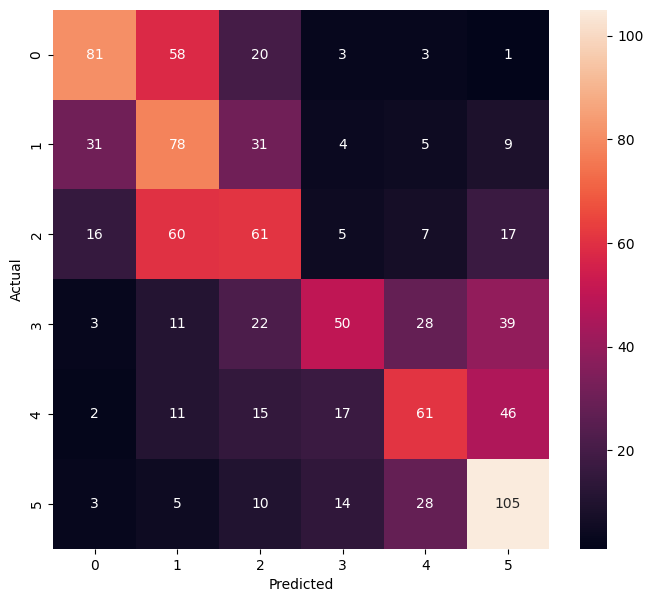

In [ ]:
## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Train on full dataset

In [ ]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [ ]:
pipe.fit(X_full, y_full)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

# TEST DATA

In [ ]:
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')
df_pred.head()

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


In [ ]:
df_pred['difficulty'] = pipe.predict(df_pred["sentence"])
predictions = df_pred.drop(columns=['sentence'], inplace = False)
#predictions.set_index('id',inplace = True)

predictions.to_csv('submission.csv')

In [ ]:
predictions.head(2)

,difficulty
id,
0,C2
1,A2


In [ ]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.30k/8.30k [00:01<00:00, 8.43kB/s]
Successfully submitted to Detecting the difficulty level of French texts